In [2]:
import pandas as pd
import numpy as np
import os
import random
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
import warnings
import re
from typing import Union, List



# NLTK Stopwords
nltk.download('stopwords')
stopWords_nltk = set(stopwords.words('english'))

# Ignore warnings
warnings.filterwarnings('ignore')

# Plotly imports (if needed)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

# WordCloud (if needed)
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv("news_sentiment_analysis.csv")
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


In [3]:
num_sources = df['Source'].nunique()
print(f"Anzahl der unterschiedlichen Quellen: {num_sources}")

Anzahl der unterschiedlichen Quellen: 503


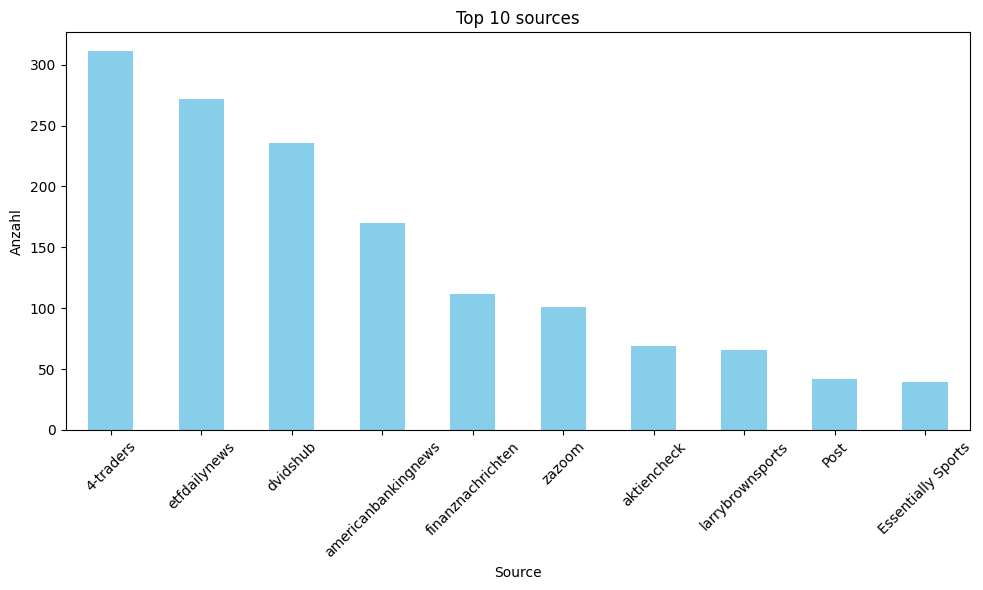

In [9]:
top_sources = df['Source'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_sources.plot(kind='bar', color='skyblue')
plt.title('Top 10 sources')
plt.xlabel('Source')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


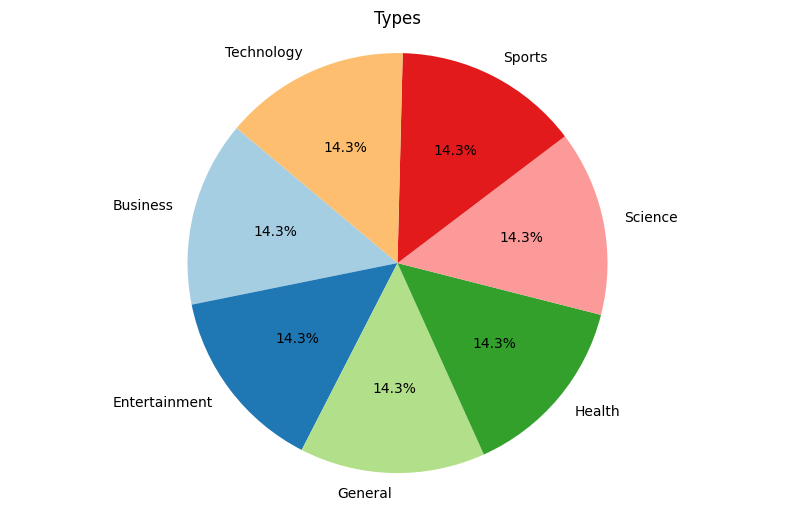

In [12]:
type_counts = df['Type'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Types')
plt.axis('equal')
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3500 non-null   object
 1   Author        2512 non-null   object
 2   Title         3500 non-null   object
 3   Description   3500 non-null   object
 4   URL           3500 non-null   object
 5   Published At  3500 non-null   object
 6   Sentiment     3500 non-null   object
 7   Type          3500 non-null   object
dtypes: object(8)
memory usage: 218.9+ KB


### Preprocess datatset for training

In [14]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Entfernen von HTML-Tags
    text = re.sub(r"http\S+", "", text)                   # Entfernen von URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)                # Entfernen von Sonderzeichen und Zahlen
    text = text.lower()                                   # Kleinbuchstaben
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopWords_nltk]
    return " ".join(words)

df['Description'] = df['Description'].apply(preprocess_text)

#### Create new column for numerical label, count characters titel and descript, clean text

In [17]:
df['Label'] = df['Sentiment'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))


In [19]:
df['Title_Length'] = df['Title'].apply(lambda x: len(str(x)))
df['Description_Length'] = df['Description'].apply(lambda x: len(str(x)))

In [20]:
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,st george kaitlyn larson first year teacher pi...,https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business,2,77,241
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,harare zimbabwe local business grappling sever...,https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business,1,54,73
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,marketscreener com billionaire elon musk donat...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business,2,67,230
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,marketscreener com u trade regulator fridayann...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business,0,67,273
4,PLANET,NaN,Rooftop solar's dark side,million household u solar panel home customer ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business,2,25,323


### Clean text manuell (experiment)

In [21]:
class CleanText():
    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern = clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:
        if isinstance(text, str):
            docs = [[text]]
        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]
        return text

In [22]:
cleaner = CleanText()


In [25]:
def clean_column(text):
    cleaned = cleaner(text)
    return cleaned[0][0]

df['Title'] = df['Title'].apply(clean_column)
df['Description'] = df['Description'].apply(clean_column)

In [26]:
df

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,st george kaitlyn larson first year teacher pi...,https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business,2,77,241
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,harare zimbabwe local business grappling sever...,https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business,1,54,73
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,marketscreener com billionaire elon musk donat...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business,2,67,230
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,marketscreener com u trade regulator fridayann...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business,0,67,273
4,PLANET,NaN,Rooftop solar's dark side,million household u solar panel home customer ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business,2,25,323
...,...,...,...,...,...,...,...,...,...,...,...
3495,etfdailynews,MarketBeat News,"Arrow Electronics, Inc. (NYSE ARW) Shares Purc...",qrg capital management inc increased stake sha...,https://www.etfdailynews.com/2024/07/18/arrow-...,2024-07-18T14:36:45+00:00,positive,Technology,2,82,231
3496,etfdailynews,MarketBeat News,"3,120 Shares in NICE Ltd. (NASDAQ NICE) Bought...",qrg capital management inc bought new position...,https://www.etfdailynews.com/2024/07/18/3120-s...,2024-07-18T14:36:44+00:00,positive,Technology,2,77,280
3497,etfdailynews,MarketBeat News,"QRG Capital Management Inc. Has 857,000 Stock...",qrg capital management inc boosted stake akama...,https://www.etfdailynews.com/2024/07/18/qrg-ca...,2024-07-18T14:36:43+00:00,positive,Technology,2,98,236
3498,finanznachrichten,NaN,Biotechnology Market Surging Investments and ...,westford mass july prnewswire according skyque...,https://www.finanznachrichten.de/nachrichten-2...,2024-07-18T14:36:00+00:00,neutral,Technology,1,119,126


### Analyse dataset

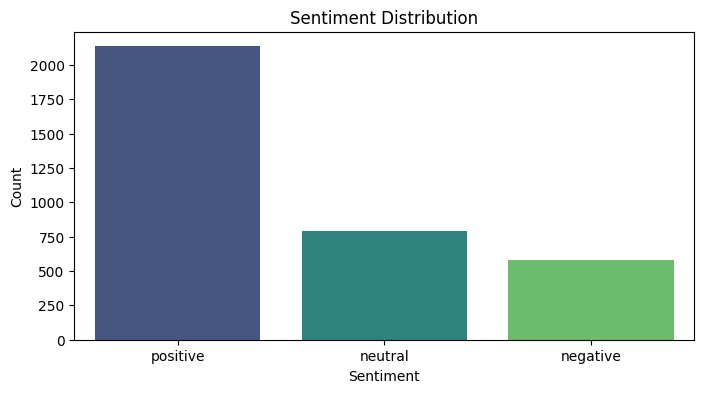

In [27]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

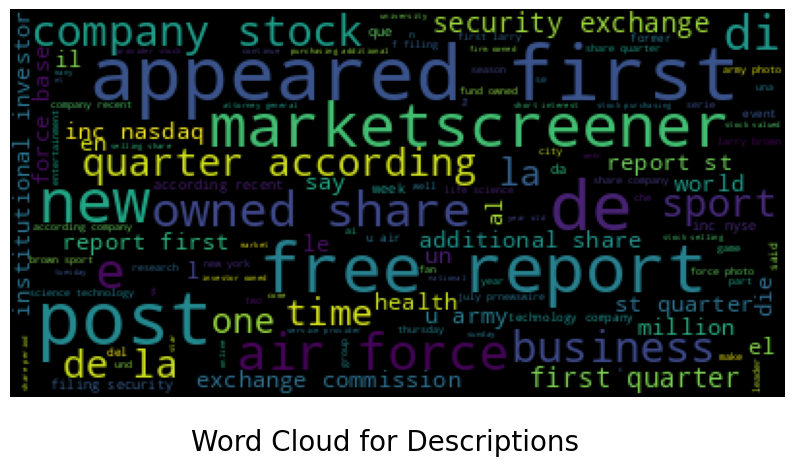

In [28]:
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
    ).generate(" ".join(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Description'], title='Word Cloud for Descriptions')

### Bert tokenizer

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
df["bert_token_length"] = df["Description"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
(df.bert_token_length <= 512).mean()


1.0

In [31]:
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length,bert_token_length
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,st george kaitlyn larson first year teacher pi...,https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business,2,77,241,39
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,harare zimbabwe local business grappling sever...,https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business,1,54,73,13
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,marketscreener com billionaire elon musk donat...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business,2,67,230,38
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,marketscreener com u trade regulator fridayann...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business,0,67,273,51
4,PLANET,NaN,Rooftop solar's dark side,million household u solar panel home customer ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business,2,25,323,50


### Analyse length depending on label

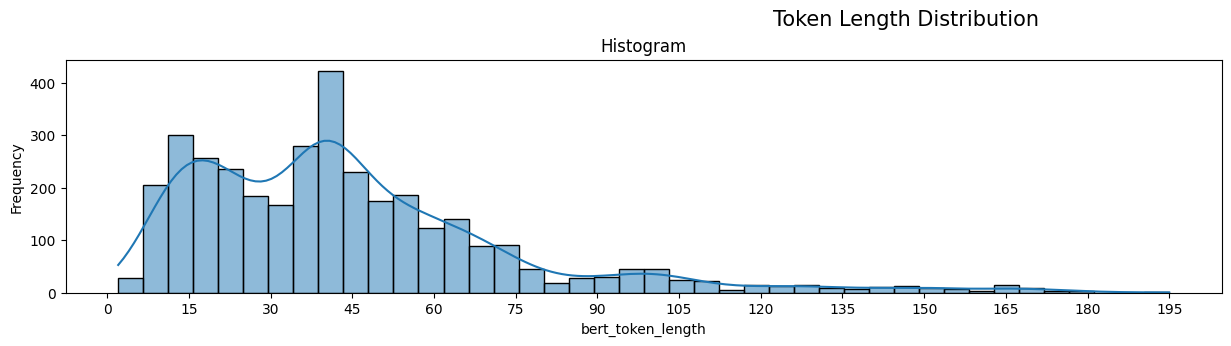

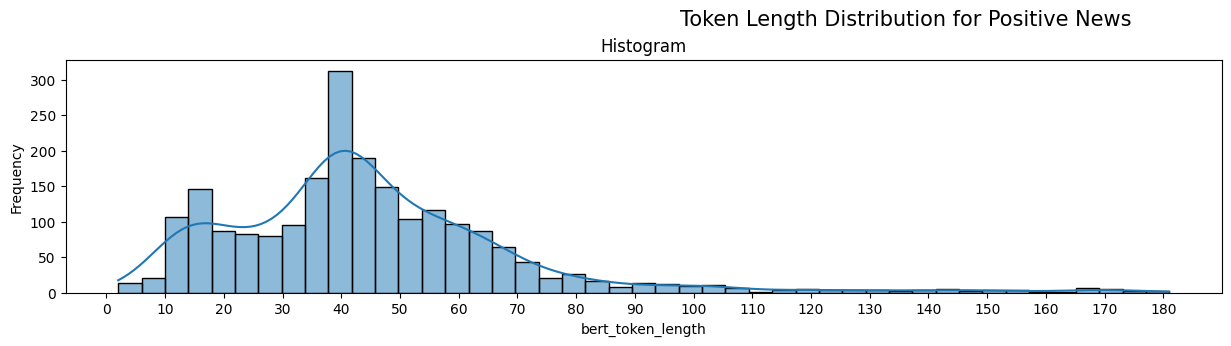

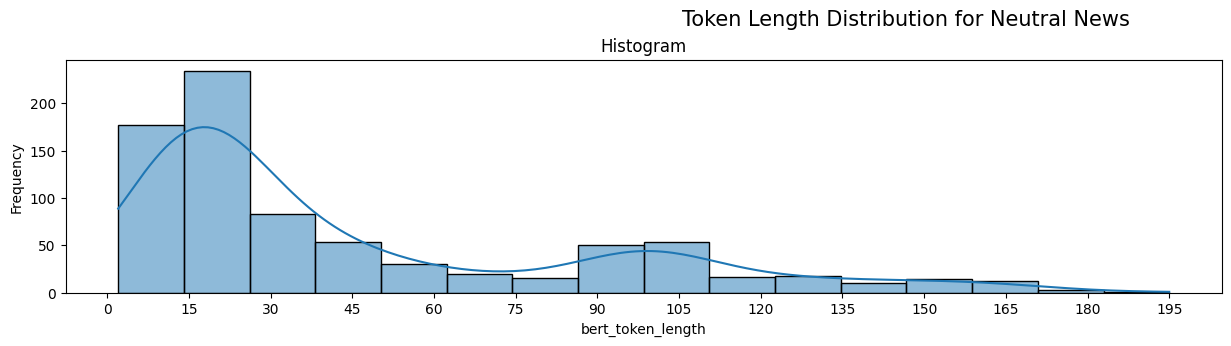

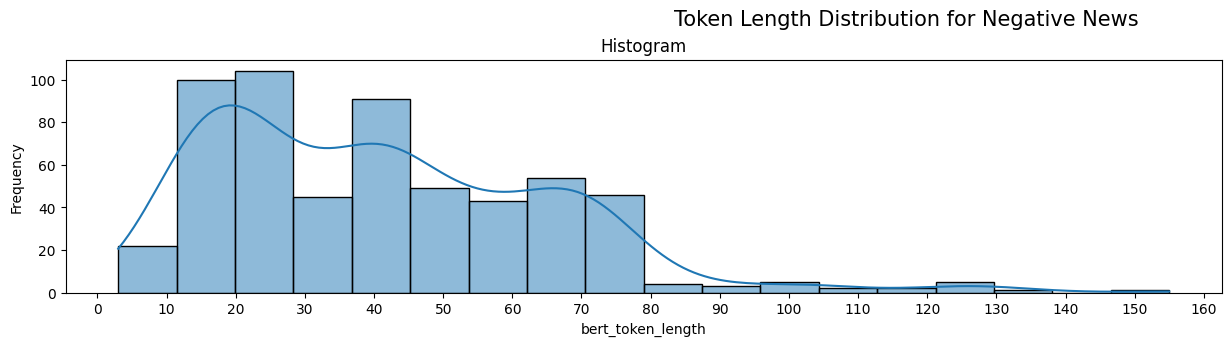

In [32]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

def plot_token_length(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.histplot(df.loc[:, feature],
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    plt.suptitle(f'{title}', fontsize=15)

plot_token_length(df, 'bert_token_length', 'Token Length Distribution')

plot_token_length(df[df['Sentiment'] == 'positive'], 'bert_token_length', 'Token Length Distribution for Positive News')
plot_token_length(df[df['Sentiment'] == 'neutral'], 'bert_token_length', 'Token Length Distribution for Neutral News')
plot_token_length(df[df['Sentiment'] == 'negative'], 'bert_token_length', 'Token Length Distribution for Negative News')



#### Prepare data

In [33]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [34]:
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [35]:
device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [36]:
train_df_, val_df = train_test_split(df,
                                    test_size=0.10,
                                    random_state=config.random_state,
                            stratify=df.Label.values)

In [37]:
train_df, test_df = train_test_split(train_df_,
                                    test_size=0.10,
                                    random_state=42,
                            stratify=train_df_.Label.values)

In [38]:
train_df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length,bert_token_length
932,laregiontam,Agencia informativa Tamaulipas,Difundir la UAT su acervo hist rico en la pla...,en un esfuerzo por incrementar el acceso los d...,https://laregiontam.com.mx/2024/07/14/difundir...,2024-07-14T21:08:26+00:00,positive,General,2,70,445,140
3159,cornwallseawaynews,ezn2_spadmin,"Two Listeria deaths were in Ontario, health mi...",toronto ontario health ministry confirmed two ...,https://www.cornwallseawaynews.com/ontario-new...,2024-07-18T17:38:45+00:00,positive,Health,2,61,248,41
767,etfdailynews,MarketBeat News,Analyzing California Resources (NYSE CRC) and ...,california resource nyse crc get free report h...,https://www.etfdailynews.com/2024/07/14/analyz...,2024-07-14T11:54:41+00:00,positive,Business,2,72,283,46
3300,Highland Radio,highlandsport,Olympics Countdown Kelly McGrory can t wait t...,tir chonaill ac kelly mcgrory going first olym...,https://highlandradio.com/2024/07/18/olympics-...,2024-07-18T19:52:36+00:00,positive,Sports,2,78,394,69
1644,gaytoday,Gay Today,Judge stops GOP attorney general from spying o...,judge joseph whyte st louis circuit court rule...,https://www.gaytoday.com/index.php/2024/07/16/...,2024-07-16T22:00:08+00:00,positive,General,2,75,161,24


In [39]:
test_df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length,bert_token_length
1936,dvidshub,Airman 1st Class Julian Atkins,Team Little Rock celebrates Juneteenth Image ...,dr sybil hampton th contracting squadron honor...,https://www.dvidshub.net/image/8532219/team-li...,2024-07-16T21:00:17+00:00,negative,Sports,0,53,288,47
2776,4-traders,NaN,Keysight Introduces PCIe Designer and Chiplet ...,marketscreener com improves pcie design produc...,https://www.marketscreener.com/quote/stock/KEY...,2024-07-18T15:02:09+00:00,neutral,Technology,1,108,296,43
777,etfdailynews,MarketBeat News,"4,992 Shares in FTI Consulting, Inc. (NYSE FCN...",quantbot technology lp bought new stake fti co...,https://www.etfdailynews.com/2024/07/14/4992-s...,2024-07-14T11:26:45+00:00,positive,Business,2,82,268,44
2403,dvidshub,Sgt. James Lundy,18th Field Artillery Brigade receives treatmen...,soldier th field artillery brigade receives tr...,https://www.dvidshub.net/image/8536713/18th-fi...,2024-07-18T19:54:58+00:00,neutral,Health,1,106,122,20
242,dvidshub,Senior Airman J. Michael Pena,3rd Wing commander completes final flight Ima...,u air force airman st class anthony vendola cr...,https://www.dvidshub.net/image/8527017/3rd-win...,2024-07-12T21:53:54+00:00,negative,General,0,57,329,65


### Tokenizer and model

In [40]:
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)


In [41]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Description.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Description.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [42]:
print("Encoded Training Data:")
print(encoded_data_train)

print("\nEncoded Validation Data:")
print(encoded_data_val)

Encoded Training Data:
{'input_ids': tensor([[  101,  4372,  4895,  ...,     0,     0,     0],
        [  101,  4361,  4561,  ...,     0,     0,     0],
        [  101,  2662,  7692,  ...,     0,     0,     0],
        ...,
        [  101,  2761,  2405,  ...,     0,     0,     0],
        [  101,  6089, 24410,  ...,     0,     0,     0],
        [  101,  5735,  5211,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

Encoded Validation Data:
{'input_ids': tensor([[  101,  6583,  2818,  ...,     0,     0,     0],
        [  101,  2334,  3076

In [43]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.Label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.Label.values)

In [44]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### Finetune Bert

In [45]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

In [49]:
optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

In [50]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [51]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [52]:
config.device

device(type='cuda', index=0)

In [53]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/473 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7122550960669558
Validation loss: 0.5317781059923818
F1 Score (Weighted): 0.7931271469244783


Epoch 2:   0%|          | 0/473 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.44229139972982207
Validation loss: 0.4969349467605984
F1 Score (Weighted): 0.8393122304836688


Epoch 3:   0%|          | 0/473 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2666455476764337
Validation loss: 0.48464726319860163
F1 Score (Weighted): 0.8794859915746815


Epoch 4:   0%|          | 0/473 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.14077046732863718
Validation loss: 0.5401788691258043
F1 Score (Weighted): 0.8805105561788027


Epoch 5:   0%|          | 0/473 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07263857845032891
Validation loss: 0.5743758989038278
F1 Score (Weighted): 0.8822700280112046


### Test dataset

In [56]:
test_df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,Label,Title_Length,Description_Length,bert_token_length
1936,dvidshub,Airman 1st Class Julian Atkins,Team Little Rock celebrates Juneteenth Image ...,dr sybil hampton th contracting squadron honor...,https://www.dvidshub.net/image/8532219/team-li...,2024-07-16T21:00:17+00:00,negative,Sports,0,53,288,47
2776,4-traders,NaN,Keysight Introduces PCIe Designer and Chiplet ...,marketscreener com improves pcie design produc...,https://www.marketscreener.com/quote/stock/KEY...,2024-07-18T15:02:09+00:00,neutral,Technology,1,108,296,43
777,etfdailynews,MarketBeat News,"4,992 Shares in FTI Consulting, Inc. (NYSE FCN...",quantbot technology lp bought new stake fti co...,https://www.etfdailynews.com/2024/07/14/4992-s...,2024-07-14T11:26:45+00:00,positive,Business,2,82,268,44
2403,dvidshub,Sgt. James Lundy,18th Field Artillery Brigade receives treatmen...,soldier th field artillery brigade receives tr...,https://www.dvidshub.net/image/8536713/18th-fi...,2024-07-18T19:54:58+00:00,neutral,Health,1,106,122,20
242,dvidshub,Senior Airman J. Michael Pena,3rd Wing commander completes final flight Ima...,u air force airman st class anthony vendola cr...,https://www.dvidshub.net/image/8527017/3rd-win...,2024-07-12T21:53:54+00:00,negative,General,0,57,329,65


In [57]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Description.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

In [58]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.Label.values)

In [59]:
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [62]:
num_labels = 3
model = BertForSequenceClassification.from_pretrained(config.pretrained_model, num_labels=num_labels)
model.load_state_dict(torch.load('./_BERT_epoch_5.model', map_location=torch.device('cpu')))
model.to(config.device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

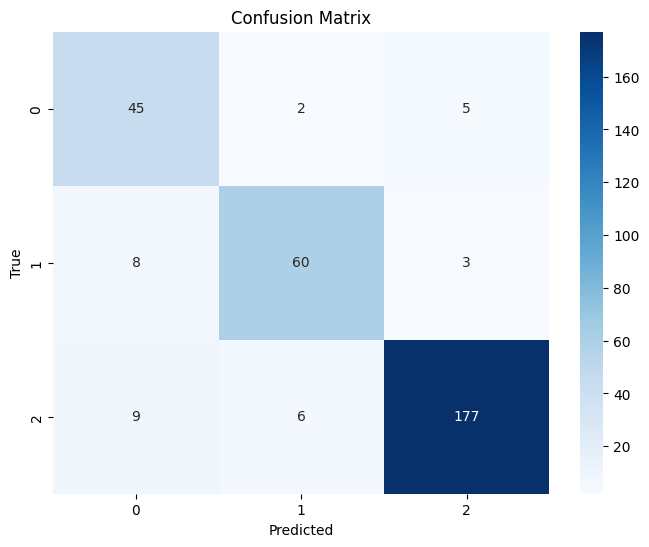

              precision    recall  f1-score   support

     Class 0       0.73      0.87      0.79        52
     Class 1       0.88      0.85      0.86        71
     Class 2       0.96      0.92      0.94       192

    accuracy                           0.90       315
   macro avg       0.85      0.88      0.86       315
weighted avg       0.90      0.90      0.90       315



In [63]:
test_dataloader = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=config.batch_size)

def predict(dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(t.to(config.device) for t in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    return predictions, true_labels

predictions, true_labels = predict(test_dataloader)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_true_labels = [item for sublist in true_labels for item in sublist]

flat_predictions = np.argmax(flat_predictions, axis=1)

conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('confusion_matrix.png')
plt.show()

report = classification_report(flat_true_labels, flat_predictions, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)

### Try own prompt (later news from scrapper)

In [64]:
num_labels = 3
model = BertForSequenceClassification.from_pretrained(config.pretrained_model, num_labels=num_labels)
model.load_state_dict(torch.load('./_BERT_epoch_5.model', map_location=torch.device('cpu')))
model.to(config.device)
model.eval()

text = "The world is nice"

encoded_data_test_single = tokenizer.encode_plus(
    text,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

input_ids_test = encoded_data_test_single['input_ids'].to(config.device)
attention_masks_test = encoded_data_test_single['attention_mask'].to(config.device)

with torch.no_grad():
    outputs = model(input_ids_test, attention_mask=attention_masks_test)


logits = outputs.logits
predictions = torch.softmax(logits, dim=1)
predicted_class = torch.argmax(predictions, dim=1).item()

print(f'Predicted class: {predicted_class}')
print(f'Probabilities: {predictions}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 2
Probabilities: tensor([[3.6014e-04, 2.4408e-04, 9.9940e-01]], device='cuda:0')


### Test model on own datatset (**news**)

In [3]:
class Config:
    pretrained_model = 'bert-base-uncased'
    add_special_tokens = True
    return_attention_mask = True
    pad_to_max_length = True
    seq_length = 128
    return_tensors = 'pt'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()

tokenizer = BertTokenizer.from_pretrained(config.pretrained_model)
model = BertForSequenceClassification.from_pretrained(config.pretrained_model, num_labels=3)

model.load_state_dict(torch.load('./_BERT_epoch_5.model', map_location=config.device))
model.to(config.device)
model.eval()

def predict_sentiment(text):
    encoded_data = tokenizer.encode_plus(
        text,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        pad_to_max_length=config.pad_to_max_length,
        max_length=config.seq_length,
        return_tensors=config.return_tensors
    )

    input_ids = encoded_data['input_ids'].to(config.device)
    attention_mask = encoded_data['attention_mask'].to(config.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(predictions, dim=1).item()

    return predicted_class, predictions

articles_df = pd.read_csv('articles.csv')

sampled_articles = articles_df.sample(n=3, random_state=10)

sampled_articles['Predicted_Sentiment'] = sampled_articles['Summary'].apply(lambda x: predict_sentiment(x)[0])

print()
print('#################### Try on own news dataset collection #############################')
print()

for index, row in sampled_articles.iterrows():
    print(f"Title: {row['Title']}\n")
    print(f"Summary: {row['Summary']}\n")
    print(f"Predicted Sentiment: {row['Predicted_Sentiment']}\n")
    print("="*80)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



#################### Try on own news dataset collection #############################

Title: How Kamala Harris’ candidacy has energized plans for the DNC

Summary: Officials quickly moved to tailor the Chicago convention to Harris with only four weeks, in part drawing from the 2008 convention when Barack Obama accepted the nomination given the historic candidacy of Harris herself.
Nominee acceptance speeches for the convention, which begins the week of August 19, are currently scheduled for that Wednesday and Thursday night, according to convention officials.
Hollywood gets on boardThe Hollywood community is clamoring to support Harris at the DNC, according to numerous agents, publicists and Democratic strategists who spoke to CNN.
No performers have been set yet, though various representatives for musicians have been in talks with the Harris campaign, according to two sources.
For instance, besides Megan Thee Stallion’s performance at her Atlanta rally earlier this week, Harris had 

In [6]:
articles_df['Predicted_Sentiment'] = articles_df['Summary'].apply(lambda x: predict_sentiment(x)[0])

In [7]:
articles_df

,Title,Summary,Date,Author,Source,URL,Title Length,Summary Length,Language,Predicted_Sentiment
0,"Kerala landslides death toll hits 151, many mi...",Hundreds of rescue workers search through mud ...,07/31/2024,NaN,www.aljazeera.com,https://www.aljazeera.com/news/2024/7/31/india...,74,667,en,0
1,World reacts to killing of Hamas political chi...,Hamas’s political chief was in Tehran when he ...,07/31/2024,NaN,www.aljazeera.com,https://www.aljazeera.com/news/2024/7/31/react...,64,691,en,0
2,Why protest by ethnic Baloch has put Pakistan’...,"Islamabad, Pakistan — Tensions are high in Pak...",07/31/2024,Abid Hussain,www.aljazeera.com,https://www.aljazeera.com/news/2024/7/31/why-p...,74,841,en,0
3,‘Childless cat ladies’: Has JD Vance taken on ...,Trump had chosen Vance as his running mate ahe...,07/30/2024,Sarah Shamim,www.aljazeera.com,https://www.aljazeera.com/news/2024/7/30/child...,66,547,en,0
4,"Far-right protesters target Southport mosque, ...",Merseyside Police said that 22 officers were i...,07/31/2024,NaN,www.aljazeera.com,https://www.aljazeera.com/news/2024/7/31/far-r...,66,664,en,0
...,...,...,...,...,...,...,...,...,...,...
162,Takeaways From Our Investigation Into Banned A...,"The United States has tried, with some success...",08/04/2024,Ana Swanson,www.nytimes.com,https://www.nytimes.com/2024/08/04/technology/...,64,683,en,2
163,"With Smugglers and Front Companies, China Is S...","In the southern Chinese city of Shenzhen, a ma...",08/04/2024,"Ana Swanson, Claire Fu",www.nytimes.com,https://www.nytimes.com/2024/08/04/technology/...,72,518,en,0
164,"Meta in Talks to Use Voices of Judi Dench, Awk...","Meta is in discussions with Awkwafina, Judi De...",08/02/2024,"Mike Isaac, Nicole Sperling",www.nytimes.com,https://www.nytimes.com/2024/08/02/technology/...,72,902,en,2
165,Delaware Judge Questions Tesla About Vote on E...,A Delaware judge on Friday questioned lawyers ...,08/02/2024,Peter Eavis,www.nytimes.com,https://www.nytimes.com/2024/08/02/business/el...,66,973,en,0


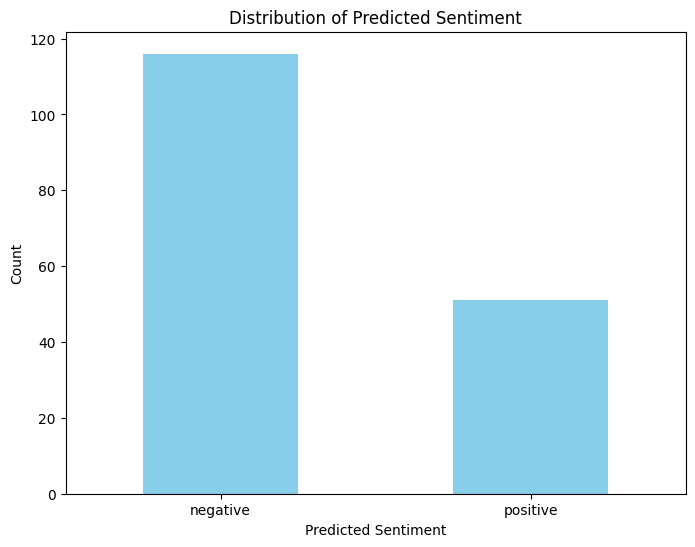

In [16]:
sentiment_labels = {0: 'negative', 2: 'positive'}
plt.figure(figsize=(8, 6))
articles_df['Predicted_Sentiment'].map(sentiment_labels).value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Sentiment')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

<Figure size 1000x600 with 0 Axes>

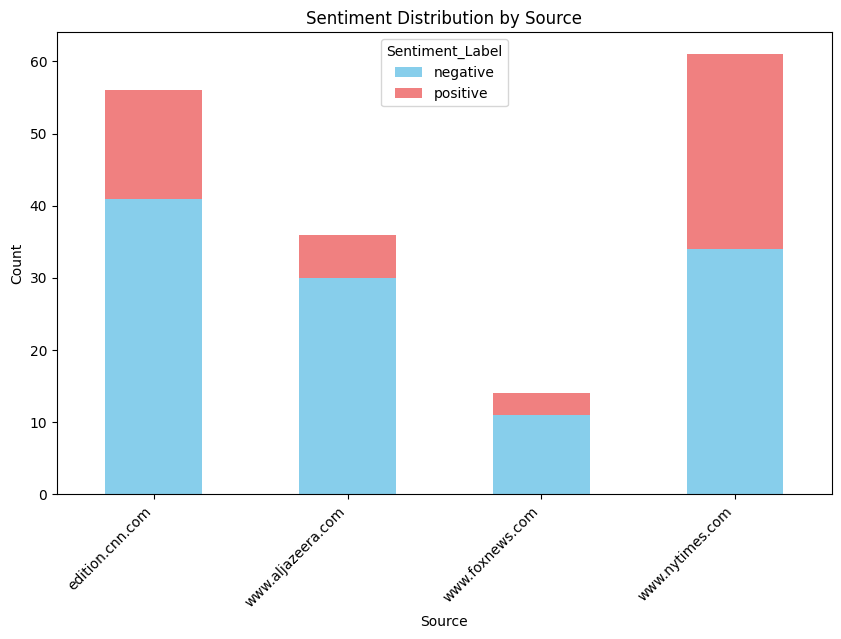

In [17]:
sentiment_labels = {0: 'negative', 2: 'positive'}

articles_df['Sentiment_Label'] = articles_df['Predicted_Sentiment'].map(sentiment_labels)

plt.figure(figsize=(10, 6))
sentiment_source = articles_df.groupby(['Source', 'Sentiment_Label']).size().unstack().fillna(0)
sentiment_source.plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'], figsize=(10, 6))

plt.title('Sentiment Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()